# Central Alps - Sud-Tyrol download

We want to cover the rectangle Basel-Bard-Trento-Innsbruck
aka `[[[7.734,45.583], [11.249,45.583], [11.249,47.517], [7.734, 47.517], [7.734,45.583]]]`.

The output of this notebook should be a file `data/AlpC-styrol-slopes.tif`

I was not able to automate the download step as the download links seem generated on the fly.

* start from [geocatalogo.retecivica.bz.it/geokatalog](http://geocatalogo.retecivica.bz.it/geokatalog/).
* in "Cerca dato", search *Modello Digitale del Terreno (DTM 2,5m)* (italian) or *Digitales Geländemodell Südtirols (DGM 2,5m)* (german)
* tick "Visualizza sulla mappa"
* in *Download* tab, *Modalità di selezione* : *Quadro d'Unione 1:10000*
* select in total **261** tiles (I hope), possibly in several steps.
* fill *email*, then *Scarica*, and receive links by emails 
* extract all links from mails with `grep -o 'http.*.zip' mails.txt >! links.txt`
* download with `wget -i links.txt`

In [3]:
# Preamble - Execute only once

%load_ext autoreload
%autoreload 2

import os
NBROOT = os.path.realpath(os.curdir)

In [4]:
# Preamble
import logging
logging.basicConfig(level=logging.DEBUG)

# stdlib
from os.path import exists, join as pjoin, realpath
from pathlib import Path
from urllib.request import urlretrieve
from zipfile import ZipFile

#external
from IPython.display import Image

# self
from src import bbox, gdal_slope_util as S
# from src.gdal_slope_util import check_run, DFLT_OPT, ZSTD_OPT, TILE_OPT

# CPL_ZIP_ENCODING for gdal vsizip:  https://github.com/conda-forge/gdal-feedstock/issues/83
os.environ['CPL_ZIP_ENCODING'] = 'UTF-8'

!mkdir -p data/dtm_final

In [5]:
STY_DTM = realpath('data/dtm_final/sudtyrol_dtm.tif')
assert(exists('data/styrol/dwnweb'))
%cd data/styrol

/home/me/code/eddy-geek/slope-ign-alti/styrol


In [35]:
sample = list(sorted(Path('dwnweb').glob('FME_*.zip')))[0]

!gdalinfo -stats "/vsizip/{$(ls -1 dwnweb/*.zip | head -1)}/DownloadService/p_bz-Elevation_DigitalTerrainModel-2.5m.tif" | grep -v '\['

# note absence of nodata value (-9999)

Driver: GTiff/GeoTIFF
Files: /vsizip/{dwnweb/FME_11060355_1638395409114_77492.zip}/DownloadService/p_bz-Elevation_DigitalTerrainModel-2.5m.tif
       /vsizip/{dwnweb/FME_11060355_1638395409114_77492.zip}/DownloadService/p_bz-Elevation_DigitalTerrainModel-2.5m.tif.aux.xml
Size is 2560, 2240
Coordinate System is:
Data axis to CRS axis mapping: 1,2
Origin = (604998.750000939238816,5176001.249877919442952)
Pixel Size = (2.499999999786324,-2.500000000239050)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  604998.750, 5176001.250) ( 10d22'27.05"E, 46d43'45.53"N)
Lower Left  (  604998.750, 5170401.250) ( 10d22'22.45"E, 46d40'44.15"N)
Upper Right (  611398.750, 5176001.250) ( 10d27'28.49"E, 46d43'41.80"N)
Lower Right (  611398.750, 5170401.250) ( 10d27'23.61"E, 46d40'40.43"N)
Center      (  608198.750, 5173201.250) ( 10d24'55.40"E, 46d42'13.00"N)
Band 1 Block=2560x410 Type=Float32, ColorInterp=Gray
  Min=-9999.000 

In [63]:
vsi = []
vrtin = 'vrt_input_files.txt'
zippath = 'DownloadService/p_bz-Elevation_DigitalTerrainModel-2.5m.tif'
with open(vrtin, 'w') as f:
    # for pzip in list(sorted(Path('dwnweb').glob('FME_*.zip')))[:5]:
    for pzip in Path('dwnweb').glob('FME_*.zip'):
        zzip = ZipFile(pzip)
        if zippath in zzip.namelist():
            f.write(f'/vsizip/{{{pzip}}}/{zippath}\n')
        else:
            print("WARN: empty", pzip)

!gdalbuildvrt -overwrite -vrtnodata -9999 -input_file_list $vrtin styrol_dtm.vrt

WARN: empty dwnweb/FME_13060355_1638440525903_53924.zip
WARN: empty dwnweb/FME_14060355_1638396308428_13056.zip
WARN: empty dwnweb/FME_13060355_1638396307846_79104.zip
WARN: empty dwnweb/FME_15060355_1638396675819_105932.zip
WARN: empty dwnweb/FME_13060355_1638396878468_71352.zip
WARN: empty dwnweb/FME_12060355_1638396850482_12780.zip
WARN: empty dwnweb/FME_11060355_1638396596677_30564.zip
WARN: empty dwnweb/FME_13060355_1638440526169_19680.zip
WARN: empty dwnweb/FME_15060355_1638396599790_73556.zip
WARN: empty dwnweb/FME_13060355_1638396604907_53856.zip
WARN: empty dwnweb/FME_14060355_1638396850212_102848.zip
WARN: empty dwnweb/FME_11060355_1638396579868_30564.zip
WARN: empty dwnweb/FME_11060355_1638396760110_30564.zip
WARN: empty dwnweb/FME_13060355_1638396702216_71352.zip
WARN: empty dwnweb/FME_13060355_1638440525287_81300.zip
WARN: empty dwnweb/FME_15060355_1638396579643_105932.zip
WARN: empty dwnweb/FME_13060355_1638396878620_53856.zip
WARN: empty dwnweb/FME_15060355_1638396675702

In [64]:
!gdalinfo -nofl styrol_dtm.vrt | rg -v '\['

Driver: VRT/Virtual Raster
Files: styrol_dtm.vrt
Size is 65280, 40320
Coordinate System is:
Data axis to CRS axis mapping: 1,2
Origin = (604998.750000939238816,5220801.249873081222177)
Pixel Size = (2.499999999734571,-2.500000000338498)
Corner Coordinates:
Upper Left  (  604998.750, 5220801.250) ( 10d23' 4.31"E, 47d 7'56.44"N)
Lower Left  (  604998.750, 5120001.250) ( 10d21'41.59"E, 46d13'31.73"N)
Upper Right (  768198.750, 5220801.250) ( 12d32' 0.92"E, 47d 5'10.23"N)
Lower Right (  768198.750, 5120001.250) ( 12d28'30.26"E, 46d10'50.66"N)
Center      (  686598.750, 5170401.250) ( 11d26'20.71"E, 46d39'40.19"N)
Band 1 Block=128x128 Type=Float32, ColorInterp=Gray
  NoData Value=-9999


In [65]:
opt = S.DFLT_OPT
!gdal_translate $opt styrol_dtm.vrt ../dtm_final/styrol_dtm.tif
# 3.3 minutes

Input file size is 65280, 40320
0...10...20...30...40...50...60...70...80...90...100 - done.


In [66]:
!gdalinfo -nofl ../dtm_final/styrol_dtm.tif | rg -v '\['

Driver: GTiff/GeoTIFF
Files: ../dtm_final/styrol_dtm.tif
Size is 65280, 40320
Coordinate System is:
Data axis to CRS axis mapping: 1,2
Origin = (604998.750000939238816,5220801.249873081222177)
Pixel Size = (2.499999999734571,-2.500000000338498)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=ZSTD
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  604998.750, 5220801.250) ( 10d23' 4.31"E, 47d 7'56.44"N)
Lower Left  (  604998.750, 5120001.250) ( 10d21'41.59"E, 46d13'31.73"N)
Upper Right (  768198.750, 5220801.250) ( 12d32' 0.92"E, 47d 5'10.23"N)
Lower Right (  768198.750, 5120001.250) ( 12d28'30.26"E, 46d10'50.66"N)
Center      (  686598.750, 5170401.250) ( 11d26'20.71"E, 46d39'40.19"N)
Band 1 Block=1024x1024 Type=Float32, ColorInterp=Gray
  NoData Value=-9999


In [67]:
res = 250
S.check_run(f'gdalwarp -overwrite -ot Byte -tr {res} {-res} ../dtm_final/styrol_dtm.tif styrol_dtm_ovr.png')
# 40 seconds

Creating output file that is 653P x 403L.
Using internal nodata values (e.g. -9999) for image ../dtm_final/styrol_dtm.tif.
Copying nodata values from source ../dtm_final/styrol_dtm.tif to destination .
0...10...20...30...40...50...60...70...80...90...100 - done.


0

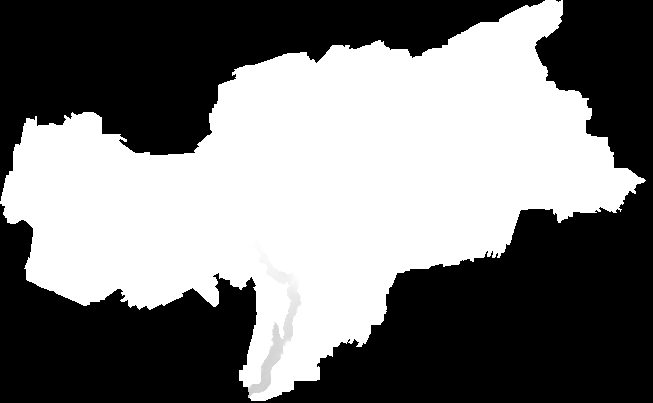

In [68]:
# If there are holes, go back to the top :)
Image('styrol_dtm_ovr.png')

In [69]:
!gdalinfo -stats ../dtm_final/styrol_dtm.tif

Driver: GTiff/GeoTIFF
Files: ../dtm_final/styrol_dtm.tif
Size is 65280, 40320
Coordinate System is:
PROJCRS["ETRS89 / UTM zone 32N",
    BASEGEOGCRS["ETRS89",
        DATUM["European Terrestrial Reference System 1989",
            ELLIPSOID["GRS 1980",6378137,298.257222101,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4258]],
    CONVERSION["UTM zone 32N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",9,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
           